In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import curve_fit

plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
t_start = 0
t_end = 24 * 6

In [3]:
data = pd.read_csv('experiment.csv')
data = [[0] + data[str(i)].to_list()[:6] for i in range(1, 4)]
data = [[data[0][i], data[1][i], data[2][i]] for i in range(6)]
data = np.cumsum(data, axis=0)

mean_srip_data = np.mean(data, axis=1)  # 各時間点での平均値
std_srip_data = np.std(data, axis=1)  # 各時間点での標準偏差

t_data = np.array([24*i for i in range(6)])

In [4]:
def model_for_fit(t, y, K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t):
    X, DNA, RNA, SRIP = y

    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser) - k_t * SRIP
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_sRNA * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    # print(t, dXdt, dDNAdt, dRNAdt, dSRIPdt) if dXdt < 0 else None
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

params_fix = [
    # P,             X_max, Ser,    k_DNA,        
    [math.log(2)/24, 1.3e6, 4.0e-4, math.log(2)/24]
    ]

initial_param = [
    #K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t
    # [5e+1,  3e-2,   3e-2,   1e-2, 2e+3,  1e-2]
    [1.0e-5, 3.0e-2, 3.0e-2, 1.0e-2, 2.0e+3, 1.0e-2]
    #Un,    fix,    fix,    TBD,  fix,   TBD
    ]

bounds = [(1.0e-5, 1e+5), (0, 1e+5), (0, 1e+5), (0, 1.0), (0, 1e+5), (0, 1e+5)]

P, X_max, Ser, k_DNA = params_fix[0]

X_0 = 2e5
DNA_0 = 2.0 * 1e11 / X_0 * 0.8
RNA_0 = 0.0
SRIP_0 = 0.0
y0 = [X_0, DNA_0, RNA_0, SRIP_0] # X, DNA, RNA, SRIP

In [11]:
data

array([[     0.       ,      0.       ,      0.       ],
       [  8639.484308 ,   3599.785128 ,   5039.69918  ],
       [253424.873008 ,  62636.261228 , 287982.81028  ],
       [272863.712698 ,  68395.917433 , 305981.73592  ],
       [275023.583775 , 134631.963793 , 306701.6929457],
       [276463.497826 , 134631.963793 , 307421.6499714]])

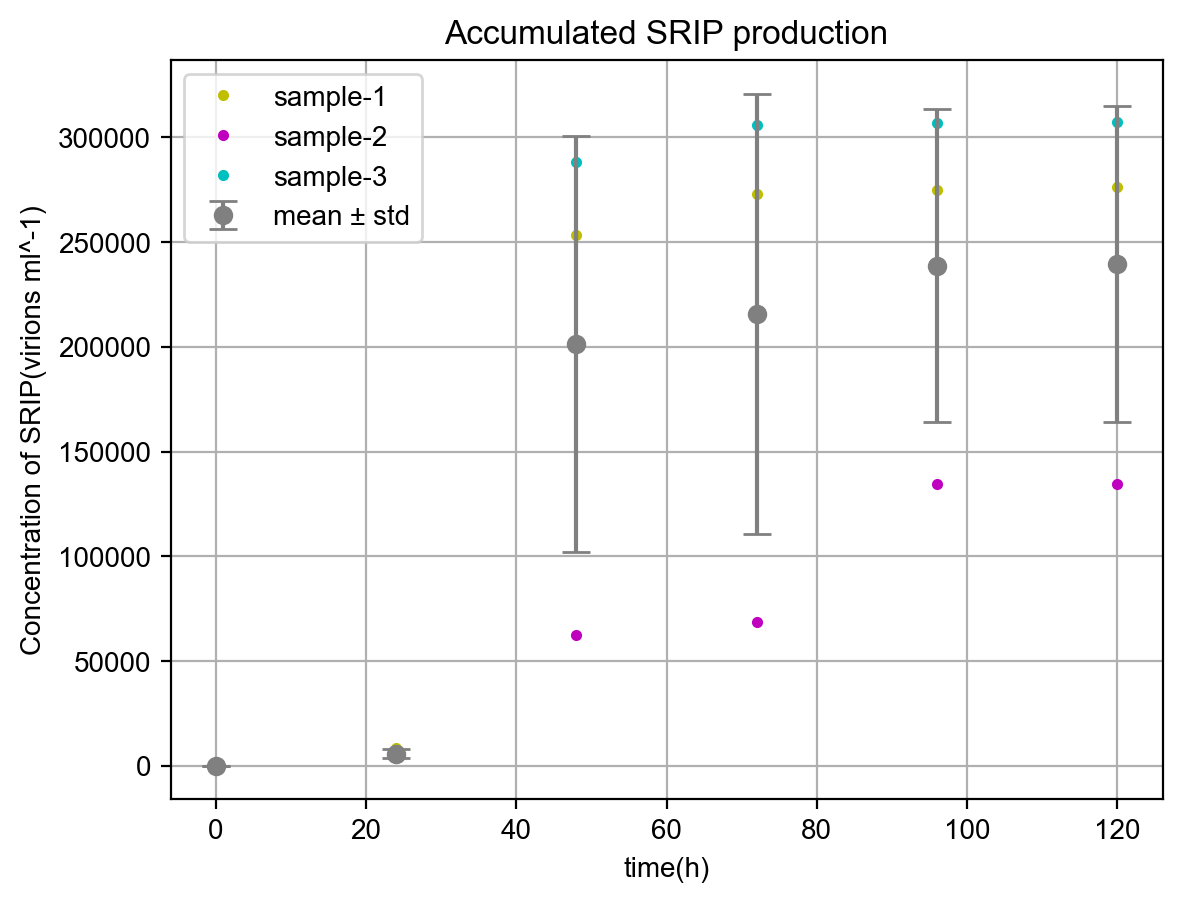

In [70]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)
color_list = ['y', 'm', 'c']

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        if i == 0:
            ax.plot(24 * i, datum[j], '.', color=color_list[j], label=f'sample-{j+1}')
        else:
            ax.plot(24 * i, datum[j], '.', color=color_list[j])


ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='mean ± std', color='gray', capsize=5)

ax.set_title('Accumulated SRIP production')
ax.set_xlabel('time(h)')
ax.set_ylabel('Concentration of SRIP(virions ml^-1)')
# ax.set_ylim(0, 5e5)
ax.grid()
ax.legend()

最適化されたパラメータ(full): [1.00000000e-05 1.53776699e-06 4.10758647e-02 9.99999161e-01
 9.74185952e+02 5.42939414e-02]


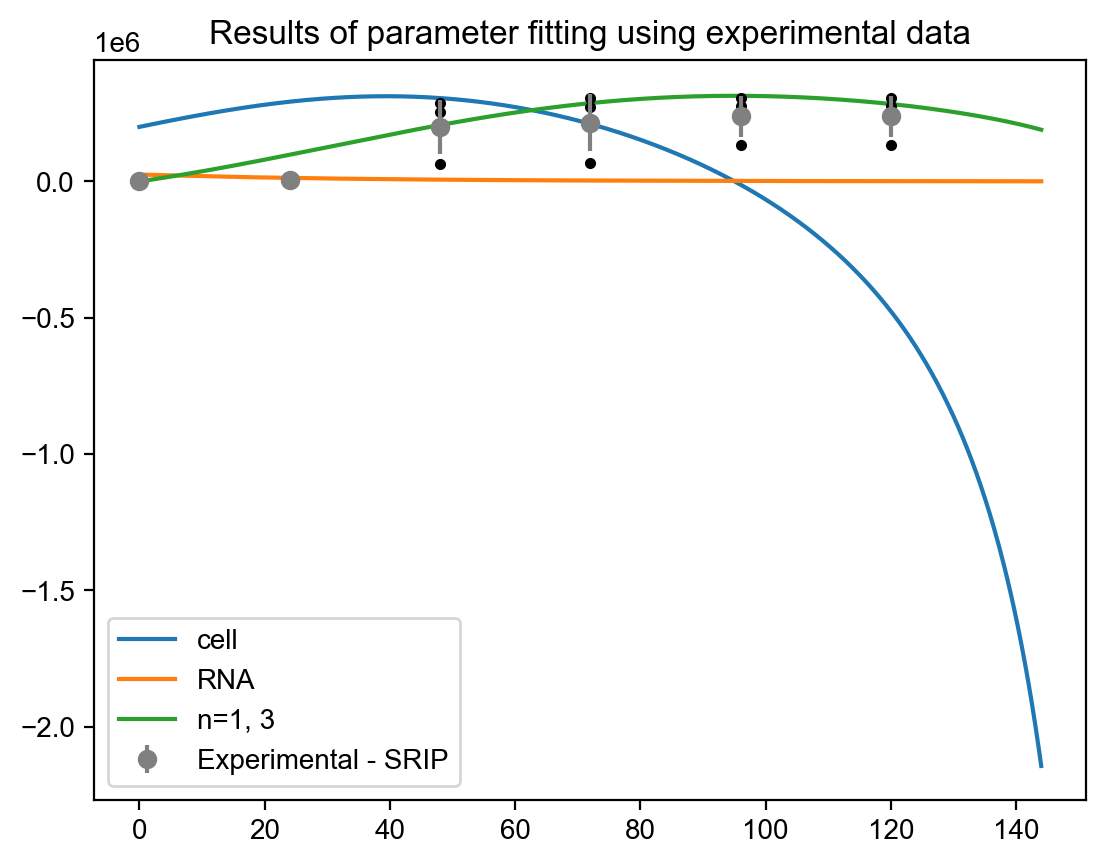

In [24]:
def fit_function(t, K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t):
    sol = solve_ivp(model_for_fit, [t_start, t_end], y0, args=(K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t), t_eval=t, method='RK45')
    
    return sol.y[-1]

popt_clip, _ = curve_fit(fit_function, t_data, (data[:, 0] + data[:, 2])/2, p0=initial_param[0], bounds=np.array(bounds).T)
popt_full, _ = curve_fit(fit_function, t_data, mean_srip_data, p0=initial_param[0], bounds=np.array(bounds).T)

# print('initial:', initial_param)
print('最適化されたパラメータ(full):', popt_full)

results = []

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)

K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t = popt_clip
results.append(solve_ivp(model_for_fit, [t_start, t_end], y0, args=(K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_start, t_end, 1000), method='RK45'))

K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t = popt_full
results.append(solve_ivp(model_for_fit, [t_start, t_end], y0, args=(K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_start, t_end, 1000), method='RK45'))

ax.plot(results[0].t, results[0].y[0], label='cell')
ax.plot(results[0].t, results[0].y[2], label='RNA')
ax.plot(results[0].t, results[0].y[3], label=f'n=1, 3')

# ax.plot(results[1].t, results[1].y[3], label=f'n=1, 2, 3')

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Results of parameter fitting using experimental data')

# ax.set_title('Accumulated SRIP production')
ax.set_xlabel('time(h)')
# ax.set_ylabel('Concentration of SRIP(virions ml^-1)')
# ax.set_ylim(0, 5e5)
ax.legend()

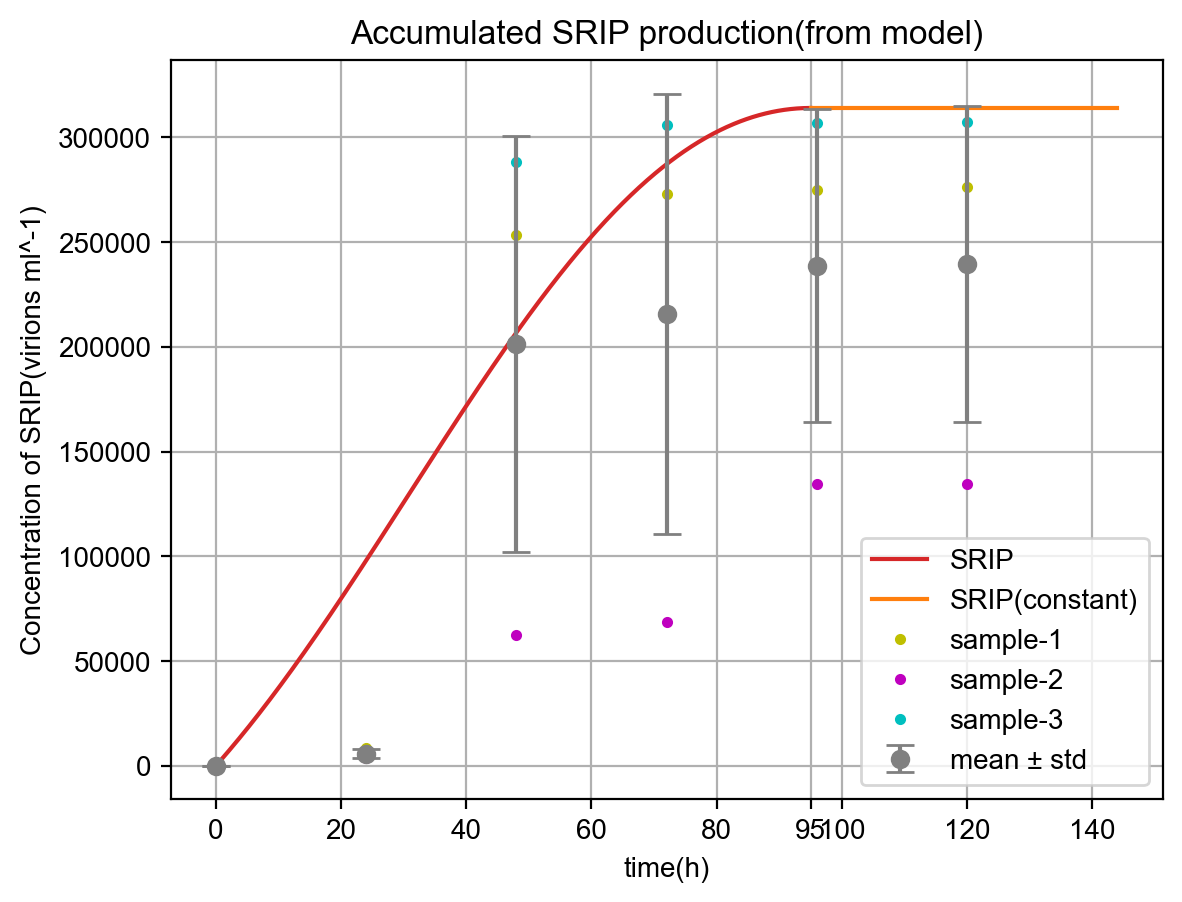

In [68]:
X_values = results[0].y[0]
DNA_value = results[0].y[1]
RNA_value = results[0].y[2]
SRIP_values = results[0].y[3]

negative_indices = np.where(X_values < 0)[0]
first_negative_index = negative_indices[0] if len(negative_indices) > 0 else None


time_interval = results[0].t[:first_negative_index]
time_interval_complement = results[0].t[first_negative_index:]

X_positive_X = X_values[:first_negative_index]
DNA_positive_X = DNA_value[:first_negative_index]
RNA_positive_X = RNA_value[:first_negative_index]
SRIP_positive_X = SRIP_values[:first_negative_index]

constant_value = SRIP_positive_X[-1]
SRIP_constant = np.full(len(results[0].t) - len(SRIP_positive_X), constant_value)
SRIP_final = np.concatenate((SRIP_positive_X, SRIP_constant))

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)

# ax.plot(time_interval, X_positive_X, label=f'cell', color='#1f77b4')
# ax.plot(time_interval, DNA_positive_X, label=f'DNA', color='#ff7f0e')
# ax.plot(time_interval, RNA_positive_X, label=f'RNA', color='#e377c2')
ax.plot(time_interval, SRIP_positive_X, label=f'SRIP', color='#d62728')
ax.plot(time_interval_complement, SRIP_constant, label='SRIP(constant)', color='#ff7f0e')


for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        if i == 0:
            ax.plot(24 * i, datum[j], '.', color=color_list[j], label=f'sample-{j+1}')
        else:
            ax.plot(24 * i, datum[j], '.', color=color_list[j])

# ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray', capsize=5)
ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='mean ± std', color='gray', capsize=5)

ax.set_title('Accumulated SRIP production(from model)')
ax.set_xlabel('time(h)')
ax.set_ylabel('Concentration of SRIP(virions ml^-1)')
ax.set_xticks([i*20 for i in range(8)] + [int(time_interval[-1])+1], [i*20 for i in range(8)] + [int(time_interval[-1]+1)])
ax.grid()
ax.legend()

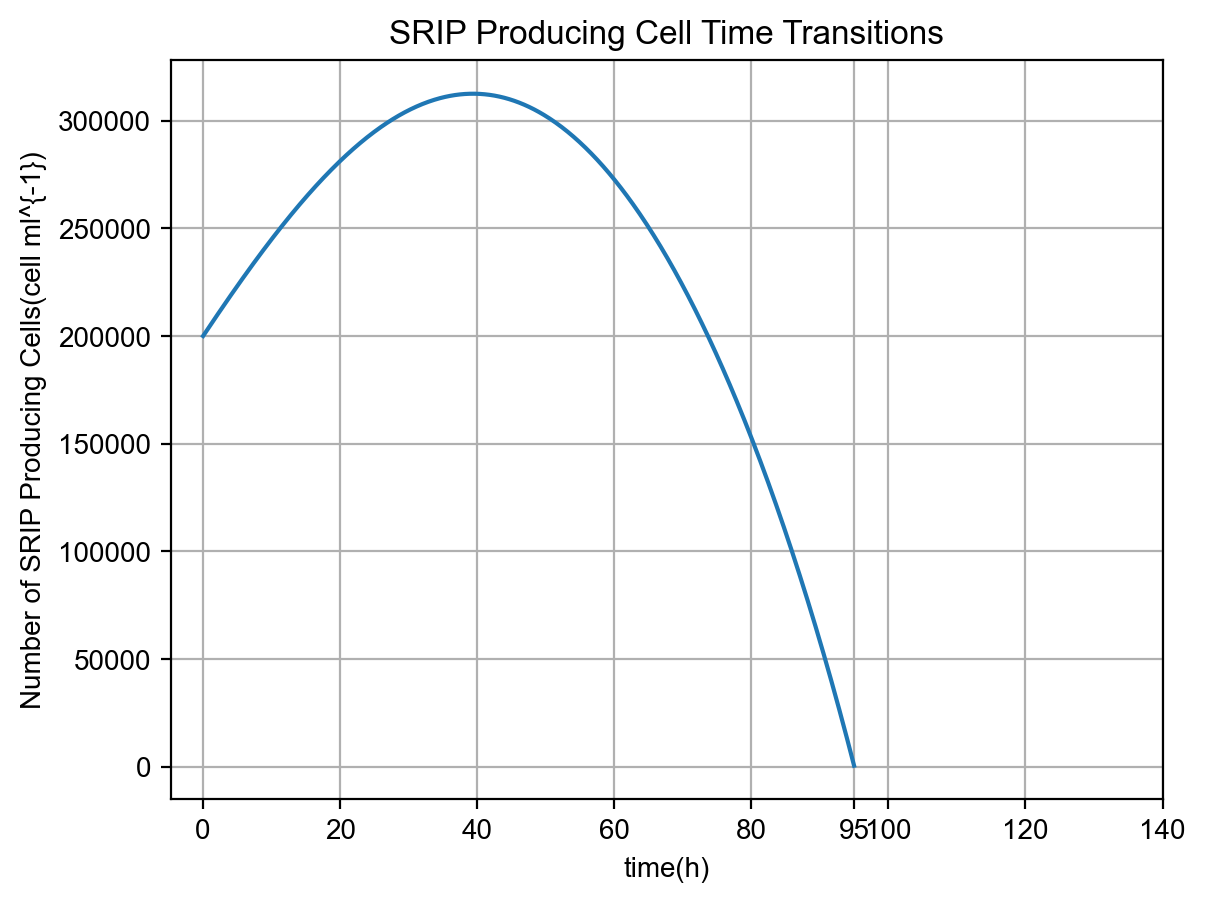

In [64]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)

ax.plot(time_interval, X_positive_X, label=f'SRIP Producing Cell', color='#1f77b4')
# ax.plot(time_interval, DNA_positive_X, label=f'DNA', color='#ff7f0e')
# ax.plot(time_interval, RNA_positive_X, label=f'RNA', color='#e377c2')
# ax.plot(time_interval, SRIP_positive_X, label=f'SRIP', color='#d62728')
# ax.plot(time_interval_complement, SRIP_constant, label='SRIP(constant)', color='#ff7f0e')


# for i in range(6):
#     datum = data[i]
#     for j in range(len(data[i])):
#         if i == 0:
#             ax.plot(24 * i, datum[j], '.', color=color_list[j], label=f'sample-{j}')
#         else:
#             ax.plot(24 * i, datum[j], '.', color=color_list[j])

# ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray', capsize=5)

ax.set_title('SRIP Producing Cell Time Transitions')
ax.set_xlabel('time(h)')
ax.set_ylabel('Number of SRIP Producing Cells(cell ml^{-1})')
ax.grid()
ax.set_xticks([i*20 for i in range(8)] + [int(time_interval[-1])+1], [i*20 for i in range(8)] + [int(time_interval[-1]+1)])


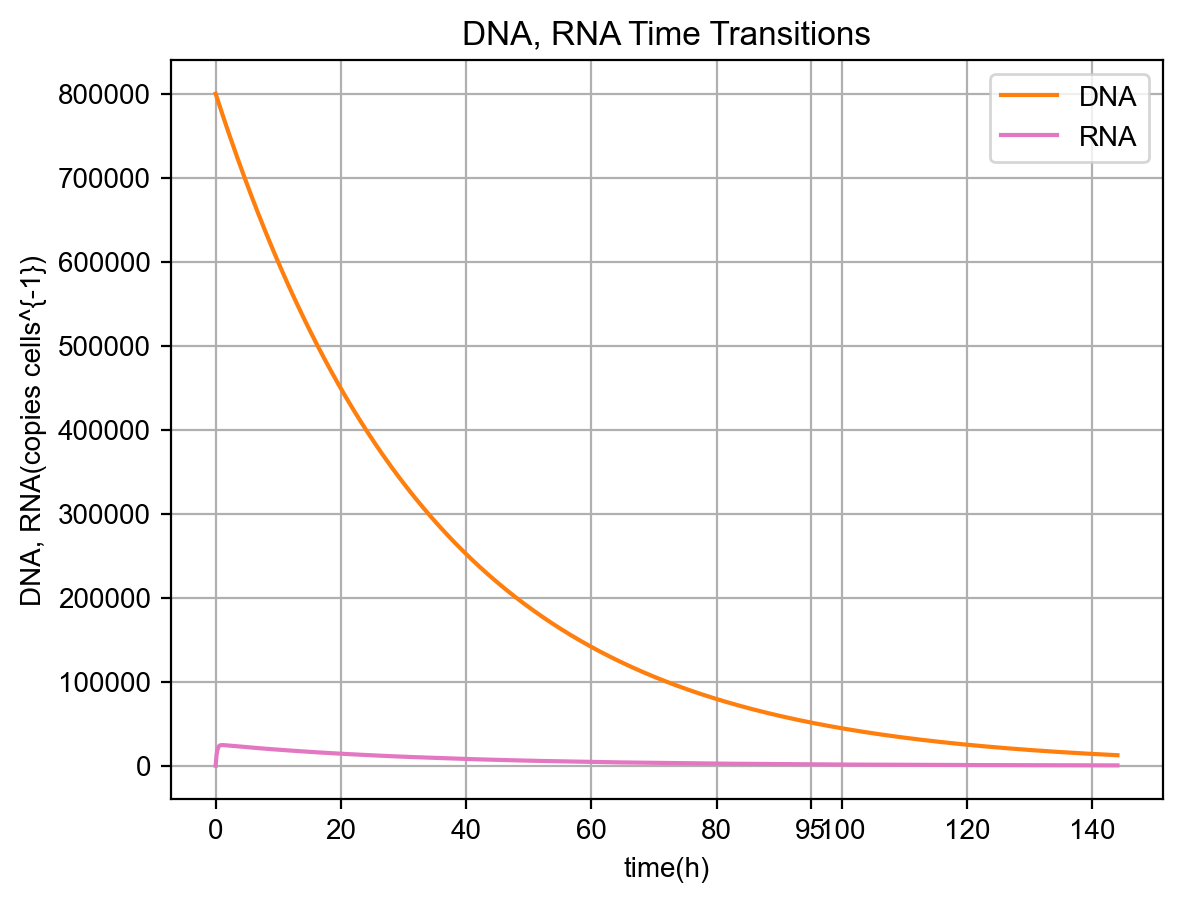

In [66]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)

# ax.plot(time_interval, X_positive_X, label=f'cell', color='#1f77b4')
# ax.plot(time_interval, DNA_positive_X, label=f'DNA', color='#ff7f0e')
# ax.plot(time_interval, RNA_positive_X, label=f'RNA', color='#e377c2')
ax.plot(results[0].t, results[0].y[1], label='DNA', color='#ff7f0e')
ax.plot(results[0].t, results[0].y[2], label='RNA', color='#e377c2')
# ax.plot(time_interval, SRIP_positive_X, label=f'SRIP', color='#d62728')
# ax.plot(time_interval_complement, SRIP_constant, label='SRIP(constant)', color='#ff7f0e')


# for i in range(6):
#     datum = data[i]
#     for j in range(len(data[i])):
#         if i == 0:
#             ax.plot(24 * i, datum[j], '.', color=color_list[j], label=f'sample-{j}')
#         else:
#             ax.plot(24 * i, datum[j], '.', color=color_list[j])

# ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray', capsize=5)

ax.set_title('DNA, RNA Time Transitions')
ax.set_xlabel('time(h)')
ax.set_ylabel('DNA, RNA(copies cells^{-1})')
ax.set_xticks([i*20 for i in range(8)] + [int(time_interval[-1])+1], [i*20 for i in range(8)] + [int(time_interval[-1]+1)])
ax.grid()
ax.legend()

In [35]:
time_interval[-1]

94.990990990991